# SHAP值

## SHAP值的基本原理
**SHAP(SHapley Additive exPlanations)**是一种基于博弈论的解释机器学习模型输出的方法。它的核心思想来源于博弈论中的Shapley值概念，用于公平地分配合作博弈中各个玩家的贡献。

在机器学习模型中：
- 每个特征被视为一个"玩家"
- 模型的预测结果被视为"游戏收益"
- SHAP值就是计算每个特征对预测结果的"边际贡献"

## SHAP值的主要特点：
   - **一致性**：如果模型改变使得某个特征更重要，其SHAP值会相应增加
   - **准确性**：所有特征的SHAP值之和等于模型预测与平均预测的差值
   - **可加性**：多个特征的SHAP值可以相加来理解它们的组合效应

## SHAP值的优缺点

- **优点**

| 优点                   | 说明                           |
| -------------------- | ---------------------------- |
| **理论保证**             | 基于博弈论，具有公平性、一致性等数学性质         |
| **通用性**              | 可用于任意机器学习模型（如 tree、NN、SVM）   |
| **局部解释**             | 可以解释每一个单独预测值                 |
| **全局解释**             | 聚合 SHAP 值可提供特征重要性排名          |
| **一致性（Consistency）** | 如果模型改进后某特征的影响变大，其 SHAP 值也会一致变大 |

- **缺点**

| 缺点           | 说明                           |
| ------------ | ---------------------------- |
| **计算复杂**     | 计算成本指数级，消耗资源较大        |
| **特征依赖性问题**  | 默认特征相互独立，可能不适用于强相关特征         |
| **可解释性误用风险** | 对模型机制不了解可能误解 SHAP 的意义        |


## SHAP值的适用场景

| 场景       | 示例                        |
| -------- | ------------------------- |
| **模型调试** | 了解模型是否学习了错误特征             |
| **特征选择** | 根据全局 SHAP 值筛选重要特征         |
| **监管解释** | 银行/医疗等对可解释性有要求的行业         |
| **客户报告** | 向非技术人员解释模型为什么做出某个预测       |
| **异常检测** | 对 SHAP 值分布分析，发现异常样本或过拟合特征 |


# 案例数据

## 波士顿房价数据集

**Boston Housing Dataset（波士顿房价数据集）**是一个回归数据集，该数据集包含506个样本，每个样本有13个特征，该数据集用于根据犯罪率、房屋房间数、空气污染等因素对波士顿地区的房价进行预测。

- MEDV：住房价格中位数（单位：千美元）
- CRIM：该镇的人均犯罪率
- ZN：住宅用地超过 25000 平方英尺的比例（%）
- INDUS：非零售商用土地比例（%）
- CHAS：是否靠近查尔斯河（1=是，0=否）
- NOX：一氧化氮浓度（空气污染指标，单位：ppm）
- RM：每栋住宅的平均房间数
- AGE：1940 年之前建成房屋的比例（%）
- DIS：到波士顿五个中心区域的加权距离
- RAD：距离高速公路的便利指数
- TAX：每 $10,000 资产的房产税率
- PTRATIO：城镇师生比例
- B：黑人比例指标
- LSTAT：低收入人群比例（%）

In [9]:
# 导入必要的库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, export_text, plot_tree
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# 加载波士顿房价数据集
# 该数据集包含506个样本，每个样本有13个特征，用于预测房价
boston = fetch_openml(name="boston", version=1, as_frame=True)
X = boston.data  # 特征变量
y = boston.target  # 目标变量（房价）
boston

{'data':         CRIM    ZN  INDUS CHAS    NOX     RM   AGE     DIS RAD    TAX  \
 0    0.00632  18.0   2.31    0  0.538  6.575  65.2  4.0900   1  296.0   
 1    0.02731   0.0   7.07    0  0.469  6.421  78.9  4.9671   2  242.0   
 2    0.02729   0.0   7.07    0  0.469  7.185  61.1  4.9671   2  242.0   
 3    0.03237   0.0   2.18    0  0.458  6.998  45.8  6.0622   3  222.0   
 4    0.06905   0.0   2.18    0  0.458  7.147  54.2  6.0622   3  222.0   
 ..       ...   ...    ...  ...    ...    ...   ...     ...  ..    ...   
 501  0.06263   0.0  11.93    0  0.573  6.593  69.1  2.4786   1  273.0   
 502  0.04527   0.0  11.93    0  0.573  6.120  76.7  2.2875   1  273.0   
 503  0.06076   0.0  11.93    0  0.573  6.976  91.0  2.1675   1  273.0   
 504  0.10959   0.0  11.93    0  0.573  6.794  89.3  2.3889   1  273.0   
 505  0.04741   0.0  11.93    0  0.573  6.030  80.8  2.5050   1  273.0   
 
      PTRATIO       B  LSTAT  
 0       15.3  396.90   4.98  
 1       17.8  396.90   9.14  
 2       

## 训练代码

Training until validation scores don't improve for 50 rounds
[50]	train's l2: 5.71956	train's l1: 1.76579	train's rmse: 2.39156	valid's l2: 12.2461	valid's l1: 2.50288	valid's rmse: 3.49944
[100]	train's l2: 0.538506	train's l1: 0.543794	train's rmse: 0.73383	valid's l2: 6.51886	valid's l1: 1.92145	valid's rmse: 2.55321
[150]	train's l2: 0.0882539	train's l1: 0.221616	train's rmse: 0.297076	valid's l2: 5.83014	valid's l1: 1.83619	valid's rmse: 2.41457
[200]	train's l2: 0.021397	train's l1: 0.108369	train's rmse: 0.146277	valid's l2: 5.68483	valid's l1: 1.82178	valid's rmse: 2.38429
[250]	train's l2: 0.00682661	train's l1: 0.0600324	train's rmse: 0.0826233	valid's l2: 5.64003	valid's l1: 1.81397	valid's rmse: 2.37487
[300]	train's l2: 0.00284788	train's l1: 0.038059	train's rmse: 0.0533655	valid's l2: 5.62899	valid's l1: 1.81231	valid's rmse: 2.37255
[350]	train's l2: 0.00135309	train's l1: 0.0265852	train's rmse: 0.0367844	valid's l2: 5.62342	valid's l1: 1.81161	valid's rmse: 2.37138
E

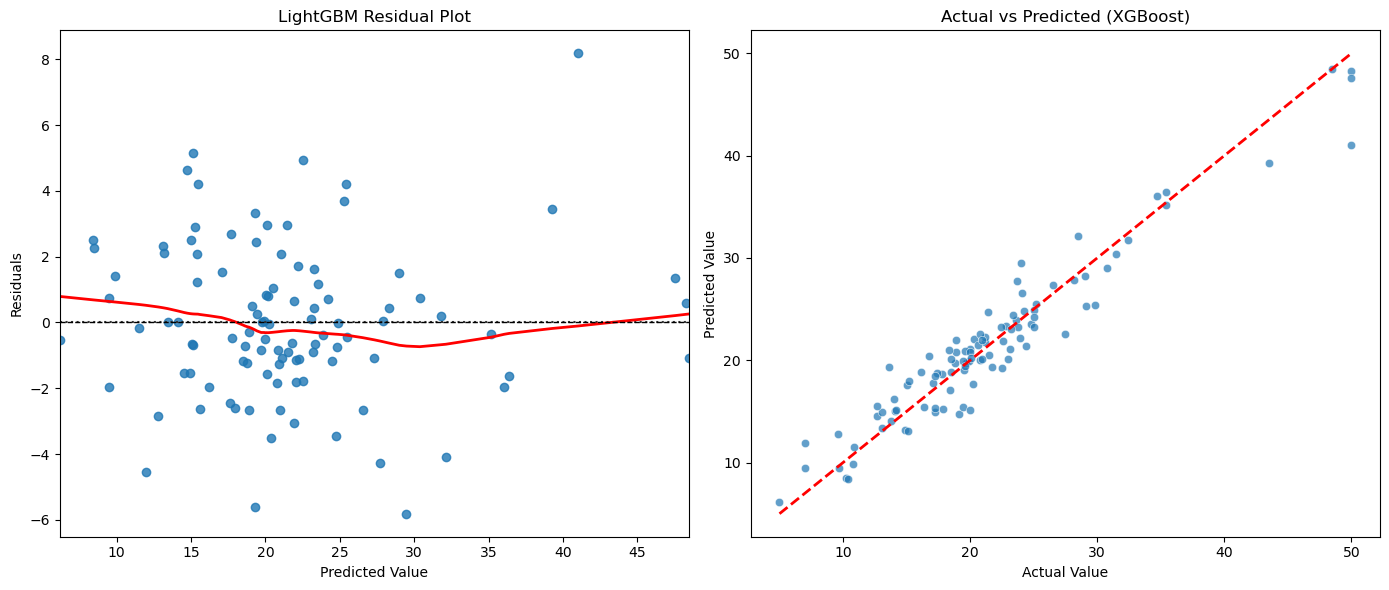

In [10]:
# 分割数据集为训练集和验证集（80% / 20%）
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ============ 4. 构建LightGBM数据集 ============
dtrain = lgb.Dataset(X_train, label=y_train)  # 训练集
dtest = lgb.Dataset(                          # 验证集
    X_test, 
    label=y_test
)

# ============ 5. 配置模型参数 ============
params = {
    # 任务类型和评估指标
    'objective': 'regression',   # 回归任务
    'metric': {'rmse','l1','l2'},   # 回归损失
    
    # 树结构控制
    'num_leaves': 60,       # 叶子节点数（控制模型复杂度）
    'max_depth': -1,        # -1表示不限制深度（通常用num_leaves控制）
    'min_data_in_leaf': 2, # 叶子节点最小样本数（防过拟合）
    
    # 训练过程控制
    'learning_rate': 0.03,  # 学习率（步长）
    'feature_fraction': 0.9, # 每轮随机选择90%特征
    'bagging_fraction': 0.8, # 每轮随机选择80%数据
    
    # 正则化
    'lambda_l1': 0.1,       # L1正则化系数
    'lambda_l2': 0.01,     # L2正则化系数
    
    # 其他
    'verbosity': -1,        # 静默模式（不输出训练日志）
    'seed': 2019    # 随机种子
}


# 训练模型
lgb_reg = lgb.train(
    params=params,
    train_set=dtrain,
    num_boost_round=1000,    # 最大迭代轮数
    valid_sets=[dtrain, dtest],  # 监控训练集和验证集表现
    valid_names=['train', 'valid'],
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),  # 早停（50轮无提升停止）
        lgb.log_evaluation(period=50)            # 每50轮打印一次日志
    ]
)

# 使用训练好的模型对验证集进行预测
y_pred = lgb_reg.predict(X_test)

# 计算多种评估指标
mse = mean_squared_error(y_test, y_pred)               # 均方误差
rmse = np.sqrt(mse)                                    # 均方根误差
mae = mean_absolute_error(y_test, y_pred)              # 平均绝对误差
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100  # 平均绝对百分比误差
r2 = r2_score(y_test, y_pred)                          # 决定系数 R²（越接近1越好）

# 输出评估指标
print("=== 评估指标 (LightGBM 原生 API) ===")
print(f"MSE:  {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE:  {mae:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R² Score: {r2:.4f}")

# 计算残差（实际值 - 预测值）
residuals = y_test - y_pred

# 创建可视化图像（2 个子图）
plt.figure(figsize=(14, 6))

# 子图1：残差图（理想情况下残差应围绕0对称分布）
plt.subplot(1, 2, 1)
sns.residplot(x=y_pred, y=residuals, lowess=True,
              line_kws={'color': 'red', 'lw': 2})
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.xlabel("Predicted Value")
plt.ylabel("Residuals")
plt.title("LightGBM Residual Plot")

# 子图2：实际值 vs 预测值（越接近对角线越好）
plt.subplot(1, 2, 2)
sns.scatterplot(x=y_test, y=y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
         'r--', lw=2)
plt.xlabel("Actual Value")
plt.ylabel("Predicted Value")
plt.title("Actual vs Predicted (XGBoost)")

# 自动调整图像排版
plt.tight_layout()
plt.show()

# shap可视化——单条样本可视化方法

## 初始化解释器&计算shap值

`shap.initjs()`
- `shap.initjs()`是 SHAP 库中的一个 初始化函数，主要用于在 Jupyter Notebook 或 JupyterLab 环境下启用可视化功能。它会在后台引入必要的 JavaScript 库，使得 SHAP 值的交互式图（如 force plot）能够正确渲染。

`shap.Explainer()`

**输入参数**
- `model`: 待解释的机器学习模型
- `masker`: 定义如何屏蔽输入特征以计算基准值
- `algorithm`: 计算算法。默认值‘auto’
- `feature_names`: 特征名称
- `seed`: 随机种子

**方法**
- `X`: 要解释的输入数据，形状一般为 (n_samples, n_features)
- `y`: 可选：目标值，供某些解释器评估模型误差时使用（通常可省略）

**属性**
- `expected_value`: 返回模型预测的期望值（基线），通常是解释的参考点
- `model`: 返回解释器绑定的模型对象

In [11]:
import shap
shap.initjs()

# 初始化解释器
explainer = shap.Explainer(lgb_reg)

# 计算 SHAP 值（针对验证集）
shap_values = explainer(X_test)

In [12]:
X_test

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
173,0.09178,0.0,4.05,0,0.510,6.416,84.1,2.6463,5,296.0,16.6,395.50,9.04
274,0.05644,40.0,6.41,1,0.447,6.758,32.9,4.0776,4,254.0,17.6,396.90,3.53
491,0.10574,0.0,27.74,0,0.609,5.983,98.8,1.8681,4,711.0,20.1,390.11,18.07
72,0.09164,0.0,10.81,0,0.413,6.065,7.8,5.2873,4,305.0,19.2,390.91,5.52
452,5.09017,0.0,18.10,0,0.713,6.297,91.8,2.3682,24,666.0,20.2,385.09,17.27
...,...,...,...,...,...,...,...,...,...,...,...,...,...
412,18.81100,0.0,18.10,0,0.597,4.628,100.0,1.5539,24,666.0,20.2,28.79,34.37
436,14.42080,0.0,18.10,0,0.740,6.461,93.3,2.0026,24,666.0,20.2,27.49,18.05
411,14.05070,0.0,18.10,0,0.597,6.657,100.0,1.5275,24,666.0,20.2,35.05,21.22
86,0.05188,0.0,4.49,0,0.449,6.015,45.1,4.4272,3,247.0,18.5,395.99,12.86


In [16]:
shap_values[2]

.values =
array([ 2.30084067e+00,  1.33502718e-02, -5.76183237e-01, -7.92758555e-03,
        1.99185167e-01, -2.38227628e+00, -6.47684031e-01, -1.26430921e-01,
       -2.22885923e-04, -2.38722941e-01, -3.59483284e-01,  2.93801533e-01,
       -1.96363401e+00])

.base_values =
22.79643243782289

.data =
array([0.10574, 0.0, 27.74, '0', 0.609, 5.983, 98.8, 1.8681, '4', 711.0,
       20.1, 390.11, 18.07], dtype=object)

## waterfall瀑布图

### 基本概念
- **功能**：SHAP瀑布图是一种针对单个样本预测结果的可解释性可视化工具，它以直观的方式展示了每个特征对模型最终预测结果的贡献程度。
- **特点**：
    - 从基准值（base value）开始逐步叠加每个特征的贡献
    - 最终到达模型预测值

### 瀑布图的组成要素

- **基值(E[f(X)])**：表示整个训练集的平均预测值，作为解释的起点
- **特征贡献条**：每个特征对应一个条形，长度表示SHAP值的大小
- **颜色编码**：通常红色表示正向贡献(增加预测值)，蓝色表示负向贡献(降低预测值)
- **最终预测值(f(x))**：位于图表最上侧，表示考虑了所有特征贡献后的最终预测结果

### `shap.plots.waterfall()`
   - `shap_values`: 必需参数，包含SHAP值的对象，通常来自shap.Explainer的计算结果
   - `max_display`: 可选参数，默认为10，控制显示的特征数量
   - `show`: 可选参数，默认为True，控制是否立即显示图形

### 代码实现与结果解释

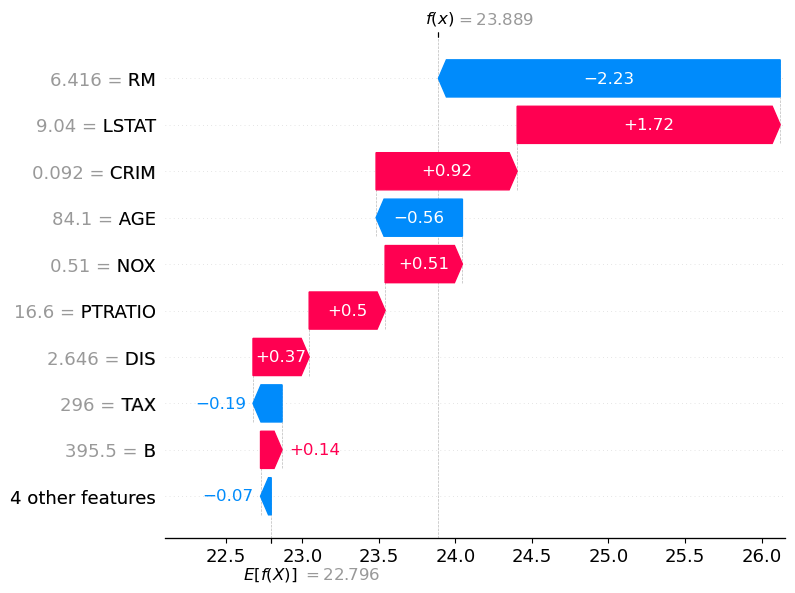

In [23]:
shap.plots.waterfall(shap_values[0])

**图表整体结构**
- **左侧**：特征名称及其实际值
- **右侧**：水平条形图显示各特征对预测的贡献值(SHAP值)
- **上方**：当前样本的最终预测值f(x)=23.889
- **下方**：基准期望值E[f(X)]=22.796(所有样本的平均预测值)

**特征贡献分析**

| 特征名        | 特征值   | SHAP值   | 贡献方向 |
|---------------|----------|----------|----------|
| RM            | 6.416    | -2.23    | 负向     |
| LSTAT         | 9.04     | +1.72    | 正向     |
| CRIM          | 0.092    | +0.92    | 正向     |
| AGE           | 84.1     | -0.56    | 负向     |
| NOX           | 0.51     | +0.51    | 正向     |
| PTRATIO       | 16.6     | +0.50    | 正向     |
| DIS           | 2.646    | +0.37    | 正向     |
| TAX           | 296      | -0.19    | 负向     |
| B             | 395.5    | +0.14    | 正向     |
| 其他4个特征   | -        | -0.07    | 负向     |

**业务解读**
- 最大正向影响因素：
    - LSTAT(低社会经济地位人口比例)：贡献+1.72
    - CRIM(犯罪率)：贡献+0.92
    - NOX(氮氧化物浓度)：贡献+0.51
- 最大负向影响因素：
    - RM(平均房间数)：贡献-2.23
    - AGE(房龄)：贡献-0.56

## decision决策路径

### 基本概念
- **核心思想**
    - **decision决策路径可视化**基于**加性特征归因**原理，直观展示模型预测从基准值(base value)到最终输出(f(x))的累积过程。其数学表达为：
    $$f(x) = \text{base_value} + \phi_1 + \phi_2 + \cdots + \phi_n$$
    其中$φᵢ$表示第$i$个特征的SHAP值。决策图通过**顺序累加**这些贡献值，形成一条从基准值到预测值的路径。

- **可视化逻辑**
    - **起点**：所有特征的共同基准(base_value)
    - **路径**：按特征重要性排序逐步累加SHAP值
    - **终点**：最终预测值(f(x))
    - **特征贡献**：每个"台阶"的高度代表对应特征的SHAP值

### 决策路径可视化的组成要素
- **核心视觉元素**

| 元素         | 描述               | 视觉编码             |
|--------------|--------------------|----------------------|
| 基准线       | 初始预测水平       | 水平虚线             |
| 决策路径     | 累积贡献路径       | 折线(通常为黑色)     |
| 特征贡献     | 单个特征的影响     | 彩色箭头/条形        |
| 特征标签     | 特征名称和值       | 左侧文本             |
| 预测标记     | 最终预测值         | 终点垂直线           |


- **坐标系统**
    - **X轴(横轴)**：无刻度，仅表示累加顺序
    - **Y轴(纵轴)**：预测值尺度，标注：
        - 基准值(base_value)
        - 最终预测值(f(x))
        - 可能的目标变量单位(如房价单位)
        
- **颜色编码系统**

| 颜色       | 典型含义     | 方向   |
|------------|--------------|--------|
| 红色       | 正向影响     | 向上   |
| 蓝色       | 负向影响     | 向下   |
| 颜色强度   | 贡献大小     | 饱和度 |


### `shap.plots.decision()`
- `base_value`: 模型在所有训练样本上的平均预测值 ($E[f(X)]$)
- `shap_values`: 必需参数，包含SHAP值的对象，通常来自shap.Explainer的计算结果
- `feature_names`: 特征名称列表
- `feature_order`: 特征排序方式
- `feature_display_range`: 控制显示的特征范围
- `plot_color`: 主绘图颜色
- `axis_color`: 坐标轴颜色
- `y_demarc_color`: 分隔线颜色
- `alpha`: 控制散点透明度。取值范围0-1，1为不透明，0为完全透明
- `color_bar`: 是否显示颜色条

### 代码实现与结果解释

In [24]:
explainer.expected_value

22.79643243782289

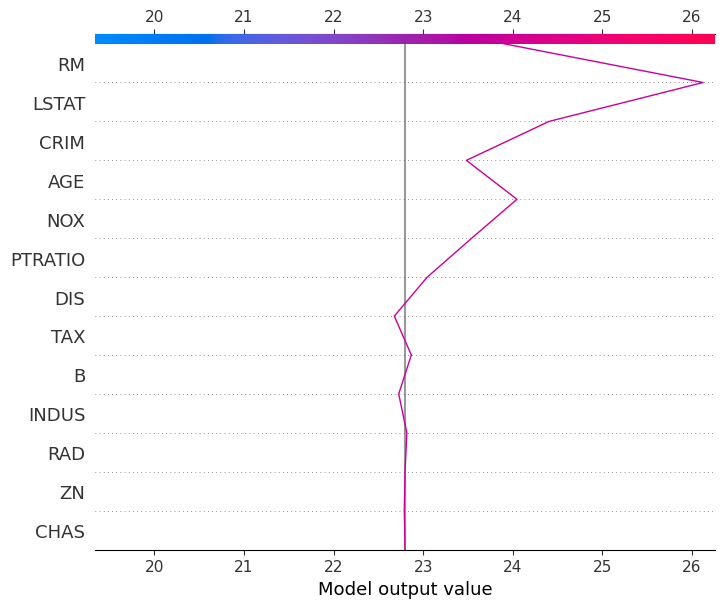

In [25]:
# 获取基准值
base_value = explainer.expected_value

# 绘制决策图（单个样本）
shap.plots.decision(
    base_value=base_value,
    shap_values=shap_values.values[0],  # 第一个样本的SHAP值
    feature_names=X_test.columns.tolist()  # 可选：添加特征名
)

**图表整体结构**
- **横轴(X轴)**：模型输出值(Model output value)，范围20-26（单位：千美元）
- **纵轴(Y轴)**：13个房价影响因素，按表格顺序从上至下排列： `RM → LSTAT → CRIM → AGE → NOX → PTRATIO → DIS → TAX → B → INDUS → RAD → ZN → CHAS
`
- **视觉编码**： 
    - 线条高度：反映特征标准化值的大小
    
**特征贡献分析**

| 特征名 | SHAP值 | 贡献方向 |
|--------|--------|----------|
| RM | -2.23 | 负向 |
| LSTAT | +1.72 | 正向 |
| CRIM | +0.92 | 正向 |
| AGE | -0.56 | 负向 |
| NOX | +0.51 | 正向 |
| PTRATIO | +0.50 | 正向 |
| DIS | +0.37 | 正向 |
| TAX | -0.19 | 负向 |

**业务解读**
- 最大正向影响因素：
    - LSTAT(低社会经济地位人口比例)：贡献+1.72
    - CRIM(犯罪率)：贡献+0.92
    - NOX(氮氧化物浓度)：贡献+0.51
- 最大负向影响因素：
    - RM(平均房间数)：贡献-2.23
    - AGE(房龄)：贡献-0.56